<a href="https://colab.research.google.com/github/PatWoo23/CreditRiskAnalysis_Project/blob/main/XGBoostModel/3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from googlcolab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning related libraries
# For lable encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Importing libraries for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
# Importing libraries for graphs
from sklearn.metrics import precision_recall_curve, roc_curve

# Importing XGBoost
from xgboost import XGBClassifier as xgb

# Importing libraries for SHAP
import shap

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/MIS561/1208_ML1.xlsx", index_col=0, header=0)
print(df.head())

             FLAG_OWN_CAR  FLAG_OWN_REALTY  NUM_CHILDREN  AMT_INCOME_TOTAL  \
CODE_GENDER                                                                  
1                       1                1             0          225000.0   
0                       1                1             1          180000.0   
1                       1                1             3          180000.0   
1                       1                0             1          180000.0   
0                       0                1             0          225000.0   

             Age  NUM_FAMILY_MEMBERS  Employment Years  \
CODE_GENDER                                              
1             66                   2               6.7   
0             42                   3               1.9   
1             39                   5               2.3   
1             32                   3              12.3   
0             36                   2               1.8   

             Average Status in Initial Phase  

In [ ]:
print(df.columns)

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NUM_CHILDREN', 'AMT_INCOME_TOTAL',
       'Age', 'NUM_FAMILY_MEMBERS', 'Employment Years',
       'Average Status in Initial Phase', 'Average Status in Current Phase',
       'Risky Customers', 'Client Classification', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'NEW_INCOME_TYPE', 'NEW_EDUCATION_TYPE',
       'NEW_FAMILY_STATUS', 'NEW_HOUSING_TYPE'],
      dtype='object')


In [ ]:
# Check and display Client Classification distribution
classification_distribution = df['Client Classification'].value_counts()
classification_percentage = (classification_distribution / len(df)) * 100
print("Client Classification distribution (count):\n", classification_distribution)
print("\nClient Classification distribution (% of total):\n", classification_percentage)



Client Classification distribution (count):
 Client Classification
0    30705
1     5411
Name: count, dtype: int64

Client Classification distribution (% of total):
 Client Classification
0    85.017721
1    14.982279
Name: count, dtype: float64


In [ ]:
# Create a DataFrame to show count and percentage side-by-side
classification_summary = pd.DataFrame({
    'Count': classification_distribution,
    'Percentage (%)': classification_percentage
})
print("\nClient Classification distribution summary:\n", classification_summary)


Client Classification distribution summary:
                        Count  Percentage (%)
Client Classification                       
0                      30705       85.017721
1                       5411       14.982279


In [ ]:
# Imbalanced Dataset: Copy df to df_smote and df_adasyn for data handling
df_smote = df.copy()
df_adasyn = df.copy()

# XGBoost

Loss function [Ref](https://machinelearningmastery.com/xgboost-loss-functions/)

From XGBoost 1.3 onward, users must explicitly set use_label_encoder=False if the target is already numeric (which it is in your case) to avoid unnecessary warnings.

xgb_classifier = xgb(

    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42

)

# Baseline Model on original dataset

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Here are the results for the baseline XGBoost model.

--------------------------------------------------

Accuracy: 0.8951
F1 Score: 0.5141
Precision: 0.8389
Recall: 0.3706
ROC-AUC: 0.8157
Confusion Matrix:
[[6065   77]
 [ 681  401]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6142
           1       0.84      0.37      0.51      1082

    accuracy                           0.90      7224
   macro avg       0.87      0.68      0.73      7224
weighted avg       0.89      0.90      0.88      7224

--------------------------------------------------


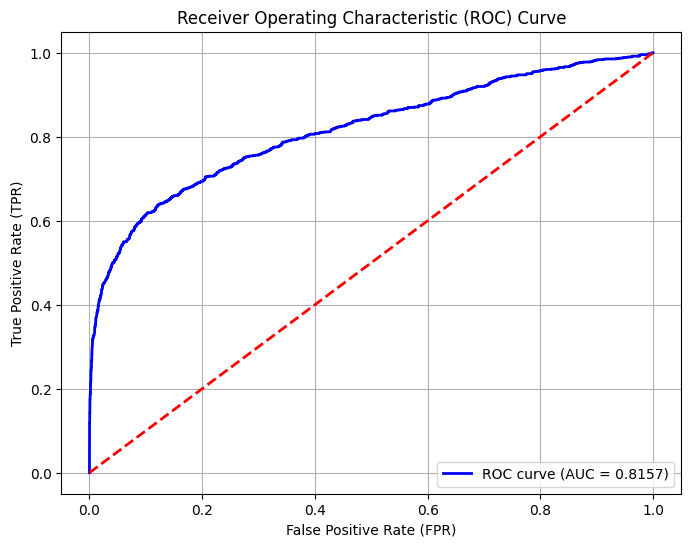

 97%|=================== | 7039/7224 [00:27<00:00]       

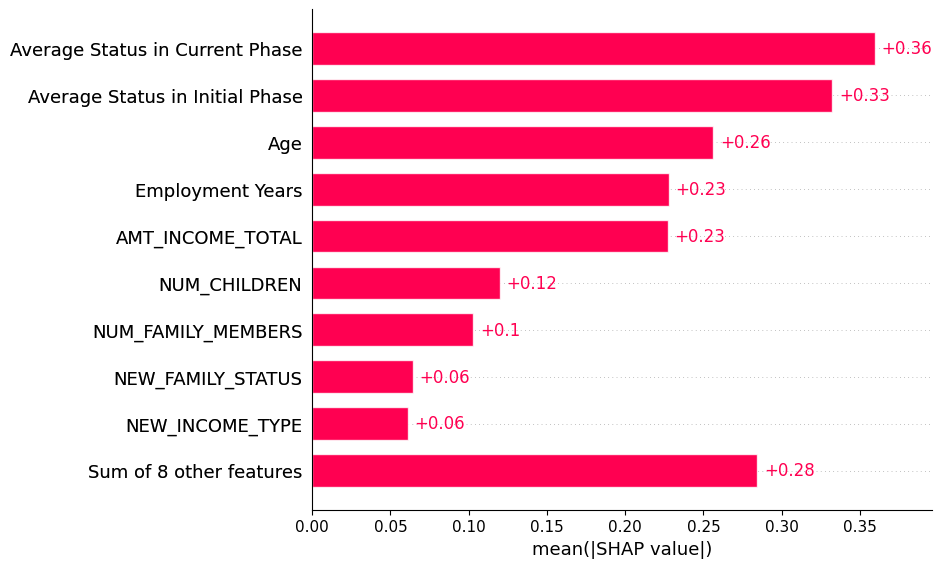

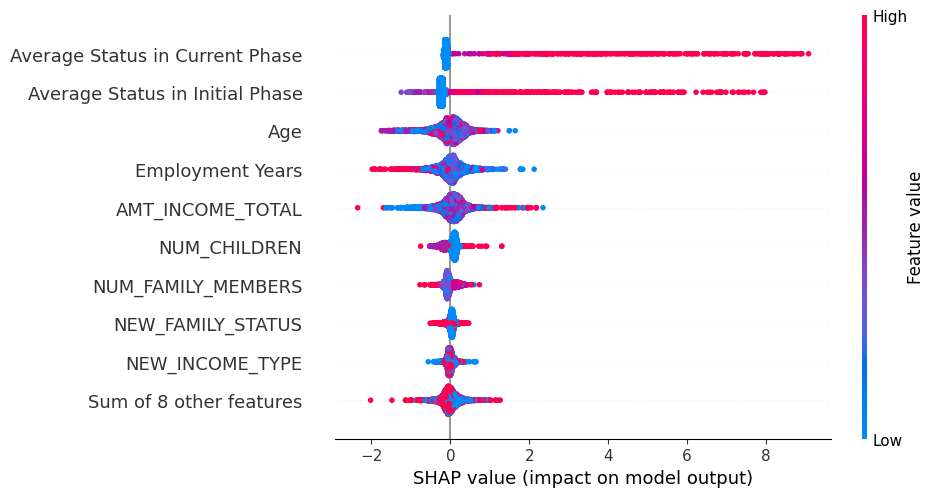

In [ ]:
# Define feature columns and target column
X = df.drop(columns=['Client Classification'])
y = df['Client Classification']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost classifier
xgb_classifier = xgb(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("\nHere are the results for the baseline XGBoost model.\n")
print('-' * 50)
print(f'\nAccuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')
print('-' * 50)

# Plot the ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# SHAP explanation
explainer = shap.Explainer(xgb_classifier, X_test)
shap_values = explainer(X_test)

# SHAP bar plot
shap.plots.bar(shap_values)

# SHAP beeswarm plot
shap.plots.beeswarm(shap_values)


# SMOTE (The best model)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Define feature columns and target column
X_s = df_smote.drop(columns=['Client Classification'])
y_s = df_smote['Client Classification']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_s, y_s)

# Check and display Client Classification distribution **AFTER SMOTE**
classification_distribution_s = y_smote.value_counts()
classification_percentage_s = (classification_distribution_s / len(y_smote)) * 100

# Create a DataFrame to show count and percentage side-by-side
classification_summary_s = pd.DataFrame({
    'Count': classification_distribution_s,
    'Percentage (%)': classification_percentage_s
})

print("\nClient Classification distribution summary (After SMOTE):\n", classification_summary_s)


Client Classification distribution summary (After SMOTE):
                        Count  Percentage (%)
Client Classification                       
0                      30705            50.0
1                      30705            50.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Here are the results for the SMOTE version of XGBoost model.

--------------------------------------------------

Accuracy: 0.8632
F1 Score: 0.8552
Precision: 0.9086
Recall: 0.8077
ROC-AUC: 0.9364
Confusion Matrix:
[[5642  499]
 [1181 4960]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      6141
           1       0.91      0.81      0.86      6141

    accuracy                           0.86     12282
   macro avg       0.87      0.86      0.86     12282
weighted avg       0.87      0.86      0.86     12282

--------------------------------------------------


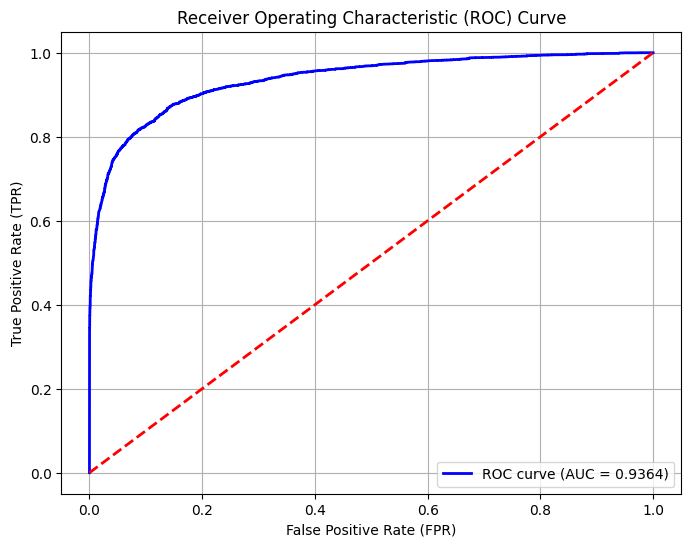

 99%|===================| 12163/12282 [00:56<00:00]       

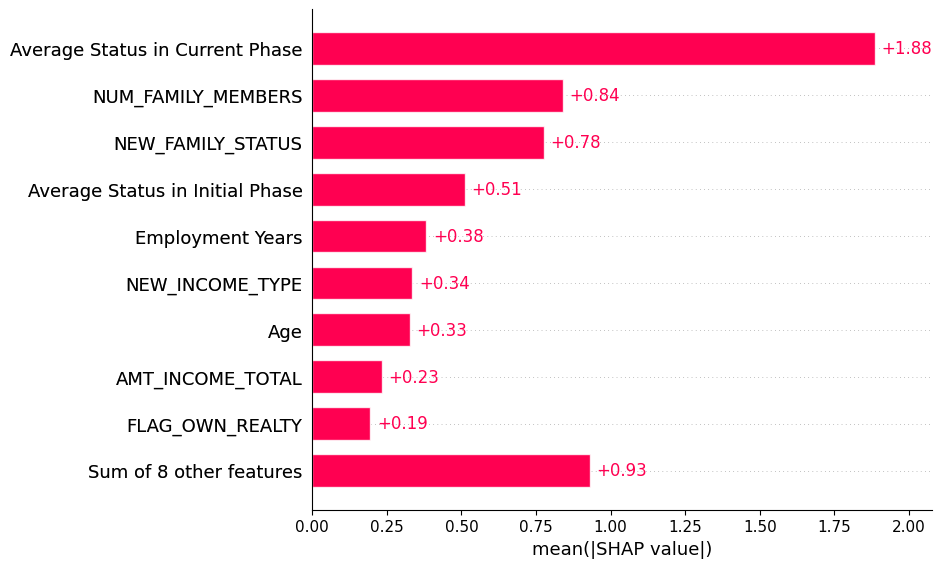

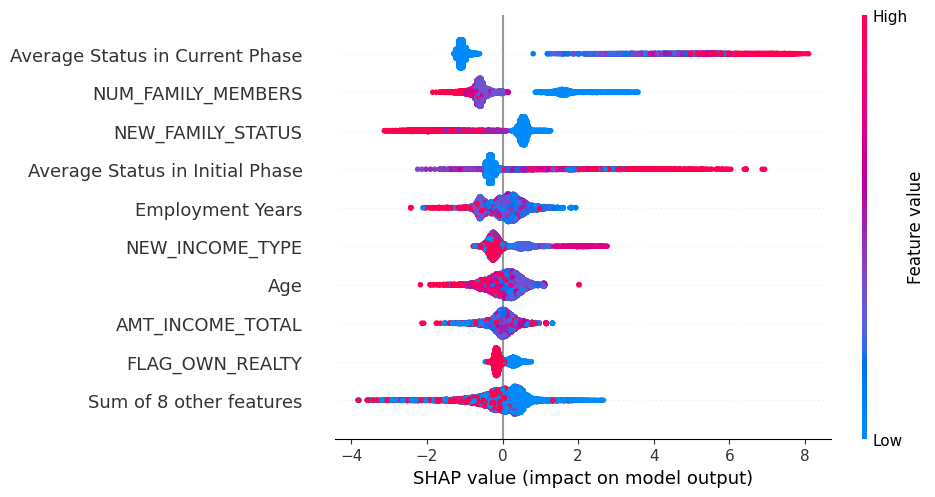

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Initialize the XGBoost classifier
xgb_classifier = xgb(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("\nHere are the results for the SMOTE version of XGBoost model.\n")
print('-' * 50)
print(f'\nAccuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')
print('-' * 50)

# Plot the ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# SHAP explanation
explainer = shap.Explainer(xgb_classifier, X_test)
shap_values = explainer(X_test)

# SHAP bar plot
shap.plots.bar(shap_values)

# SHAP beeswarm plot
shap.plots.beeswarm(shap_values)


In [ ]:
import pickle

In [ ]:
model_filename = '/content/drive/MyDrive/MIS561/xgb_classifier_model_SMOTE.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_classifier, file)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/MIS561/xgb_classifier_model_SMOTE.pkl


# ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
# Define feature columns and target column
X_a = df_adasyn.drop(columns=['Client Classification'])
y_a = df_adasyn['Client Classification']

# Apply ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_a, y_a)

# Check and display Client Classification distribution **AFTER ADASYN**
classification_distribution_a = y_adasyn.value_counts()
classification_percentage_a = (classification_distribution_a / len(y_adasyn)) * 100

# Create a DataFrame to show count and percentage side-by-side
classification_summary_a = pd.DataFrame({
    'Count': classification_distribution_a,
    'Percentage (%)': classification_percentage_a
})

print("\nClient Classification distribution summary (After ADASYN):\n", classification_summary_a)


Client Classification distribution summary (After ADASYN):
                        Count  Percentage (%)
Client Classification                       
1                      32021       51.049007
0                      30705       48.950993


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Here are the results for the ADASYN version of XGBoost model.

--------------------------------------------------

Accuracy: 0.8557
F1 Score: 0.8493
Precision: 0.9094
Recall: 0.7966
ROC-AUC: 0.9352
Confusion Matrix:
[[5633  508]
 [1303 5102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6141
           1       0.91      0.80      0.85      6405

    accuracy                           0.86     12546
   macro avg       0.86      0.86      0.86     12546
weighted avg       0.86      0.86      0.86     12546

--------------------------------------------------


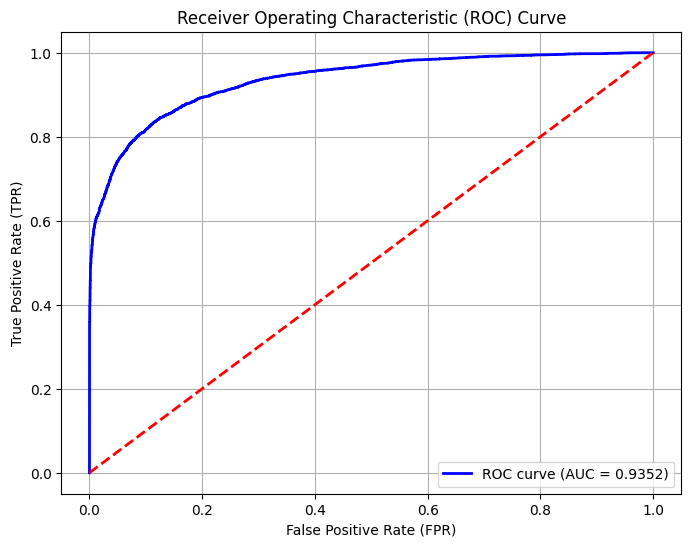

 99%|===================| 12450/12546 [00:55<00:00]       

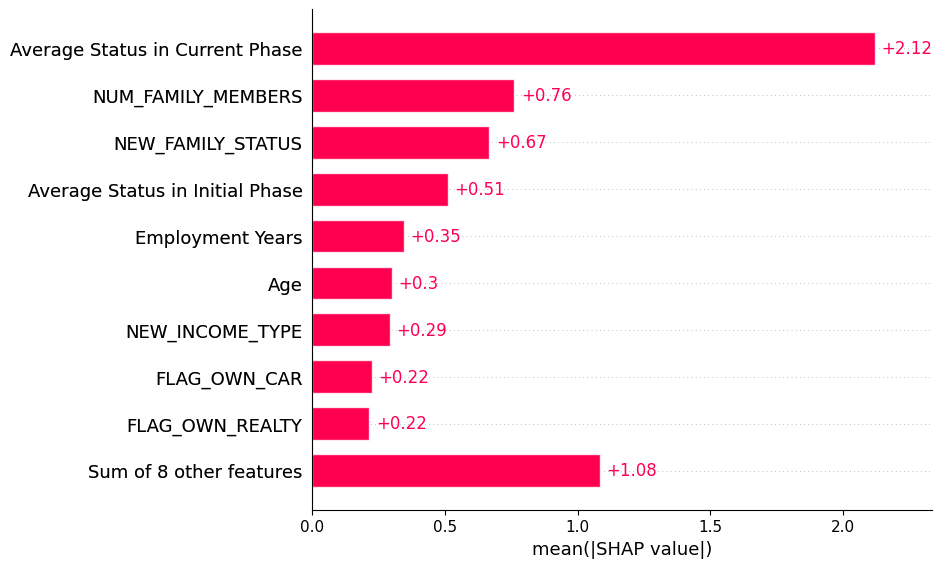

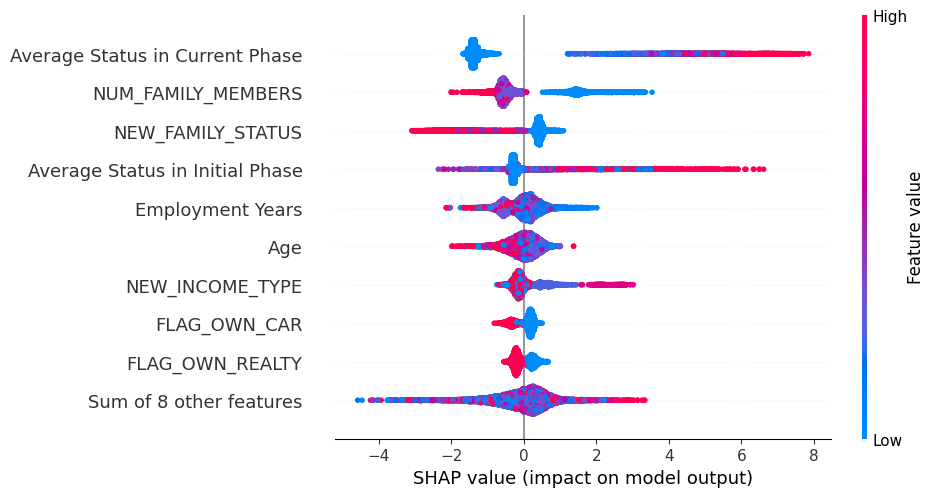

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42, stratify=y_adasyn)

# Initialize the XGBoost classifier
xgb_classifier = xgb(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("\nHere are the results for the ADASYN version of XGBoost model.\n")
print('-' * 50)
print(f'\nAccuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')
print('-' * 50)

# Plot the ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# SHAP explanation
explainer = shap.Explainer(xgb_classifier, X_test)
shap_values = explainer(X_test)

# SHAP bar plot
shap.plots.bar(shap_values)

# SHAP beeswarm plot
shap.plots.beeswarm(shap_values)
